In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [2]:
train_dir = r'D:\DATA\cat\dogs-vs-cats\train\train'
test_dir = r'D:\DATA\cat\dogs-vs-cats\test1\test1'
img_size = 50

In [3]:
def data_vis(image_show, dir_, img_size):
    i = 0
    imgs = []
    for img in os.listdir(dir_):
        img_array = cv2.imread(os.path.join(dir_, img), cv2.IMREAD_GRAYSCALE)
        imgs.append(img_array)
        i+=1
        if i == image_show:
            break
            
    for i in imgs:
        print("Before resize array shape",i.shape)
        plt.imshow(i, cmap = 'gray')
        plt.axis('off')
        plt.show()
        
    for i in imgs:
        new_array = cv2.resize(i, (img_size, img_size))
        print('After resize array shape', new_array.shape)
        plt.imshow(i, cmap = 'gray')
        plt.axis('off')
        plt.show()

Before resize array shape (374, 500)


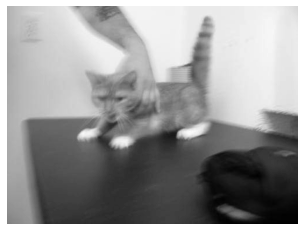

After resize array shape (50, 50)


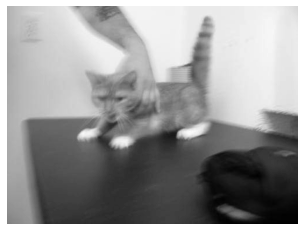

In [4]:
data_vis(1, train_dir, img_size)

In [5]:
os.listdir(train_dir)[0].split('.') # The first element will be the label

['cat', '0', 'jpg']

In [6]:
def create_trainset(dir_, img_size, data_size):
    train_set = []
    label_dict = {'dog': 1, 'cat': 0}
    i = 0
    for img in tqdm(os.listdir(dir_)):
        label = label_dict[img.split('.')[0]]
        img_array = cv2.imread(os.path.join(dir_, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        train_set.append([img_resize, label])
        i+=1
        if i == data_size:
            print('Bingo')
            break
    return train_set

In [7]:
sample = create_trainset(train_dir, img_size, 1)

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]

Bingo


In [8]:
'''
Let us take a loot at the data we create to make sure it is correct
'''
print("Shape of X:", sample[0][0].shape)
print("Y value is:", sample[0][1])

Shape of X: (50, 50)
Y value is: 0


In [9]:
'''
Now let us create our real dataset
'''
path = r'C:\Users\zhong\Desktop\UOP\project\train.pickle'
if not os.path.isfile(path):
    train_set = create_trainset(train_dir, img_size, len(os.listdir(train_dir)))

In [10]:
'''
Save file for future use
'''
if not os.path.isfile(path):
    pickle_out = open("train.pickle", 'wb')
    pickle.dump(train_set, pickle_out)
    pickle_out.close()

In [11]:
'''
Import saved trainset
'''
pickle_in = open('train.pickle', 'rb')
train_set = pickle.load(pickle_in)

In [12]:
'''
Seprate train_set into X and y
'''
def get_X_y(data):
    X = []
    y = []
    for feature, label in data:
        X.append(feature)
        y.append(label)
    return X, y

In [13]:
X, y = get_X_y(train_set)

In [14]:
'''
For CNN, the input must be 4-D array, [batch_size, width, height, channels]
Because we are doing grayscale CNN, the channel = 1
'''
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X/255
y = np.array(y).reshape(-1, 1)

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [16]:
from tensorflow.keras.callbacks import TensorBoard
import time

In [41]:
def image(filename):
    try:
        plt.figure(figsize=(20,20)) 
        img = cv2.imread(filename)
        plt.imshow(img)
        plt.axis('off')
    except:
        print('Cant Find Image')

In [ ]:
'''
I decided to try different models and use tensorboard to see which perform well
Below code is trying to run the model based different setup
'''
node = [32, 64, 128]
conv_layer = [1, 2, 3]

for conv in conv_layer:
    for size in node:
        model_name = "{}-node-{}-conv-{}".format(size, conv, int(time.time()))

        'Input layer'
        model = Sequential()
        '256 neurons, 3 by 3 filter size'
        model.add(Conv2D(size, (3,3), input_shape = X.shape[1:])) 
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        'This for loop will duplicate convolutional layer depends on the number of layer we want'
        for i in range(conv):
            model.add(Conv2D(size, (3, 3)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

        'We have to flatten the data before going into dense layer'
        model.add(Flatten()) 

        '''Output layer'''
        model.add(Dense(1))
        model.add(Activation('sigmoid'))

        'Log file'
        tensorboard = TensorBoard(log_dir = r"C:\Users\zhong\Desktop\UOP\project\logs\{name}".format(name = model_name))

        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

        model.fit(X, y, batch_size = 32, epochs = 10, validation_split = 0.2, callbacks = [tensorboard], verbose = 0)

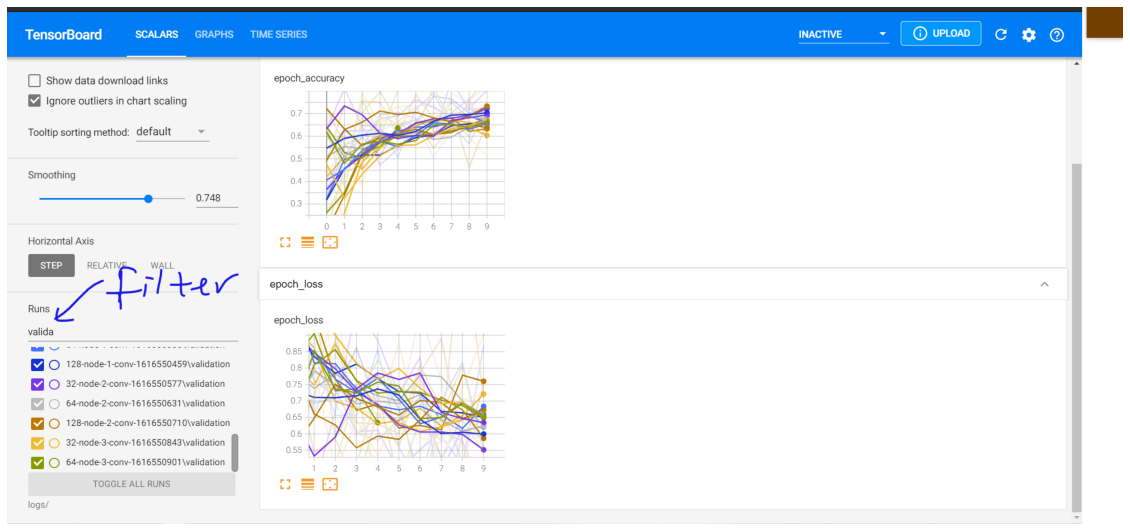

In [45]:
image(r'C:\Users\zhong\Desktop\UOP\project\cat_dog_pic\TB2.png')

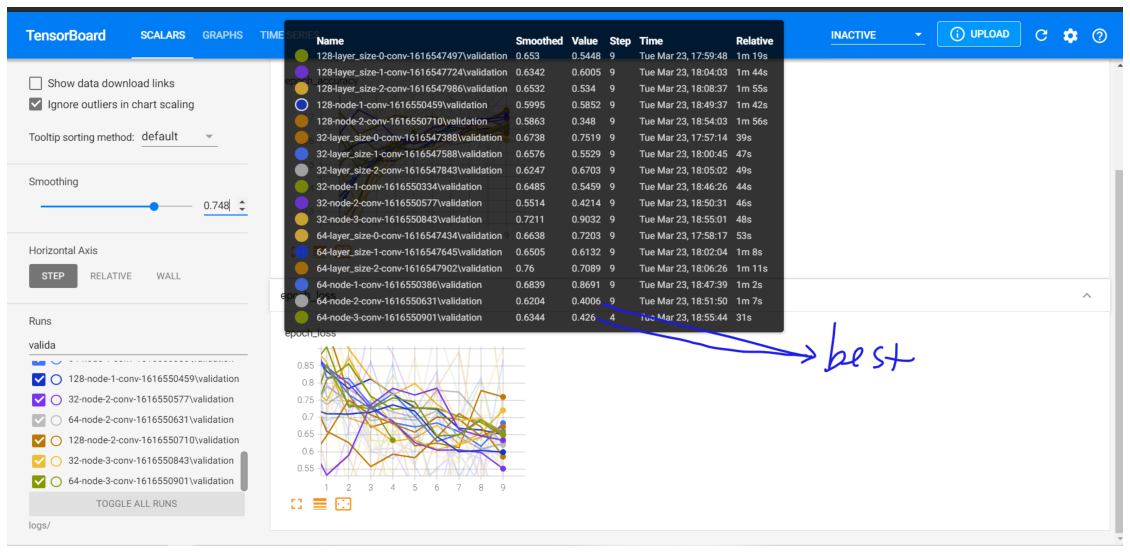

In [43]:
image(r'C:\Users\zhong\Desktop\UOP\project\cat_dog_pic\TensorBoard.png')

In [17]:
'''
Below code is used to see the validation loss and accuracy on TensorBoard for 128 node and 2 conv layers
'''

node = [64]
conv_layer = [3]

for conv in conv_layer:
    for size in node:
        model_name = "{}-node-{}-conv-{}".format(size, conv, int(time.time()))

        'Input layer'
        model = Sequential()
        '256 neurons, 3 by 3 filter size'
        model.add(Conv2D(size, (3,3), input_shape = X.shape[1:])) 
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        'This for loop will duplicate convolutional layer depends on the number of layer we want'
        for i in range(conv):
            model.add(Conv2D(size, (3, 3)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

        'We have to flatten the data before going into dense layer'
        model.add(Flatten()) 

        '''Output layer'''
        model.add(Dense(1))
        model.add(Activation('sigmoid'))

        'Log file'
        tensorboard = TensorBoard(log_dir = r"C:\Users\zhong\Desktop\UOP\project\logs\{name}".format(name = model_name))

        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

        model.fit(X, y, batch_size = 32, epochs = 10, validation_split = 0.2, callbacks = [tensorboard], verbose = 0)

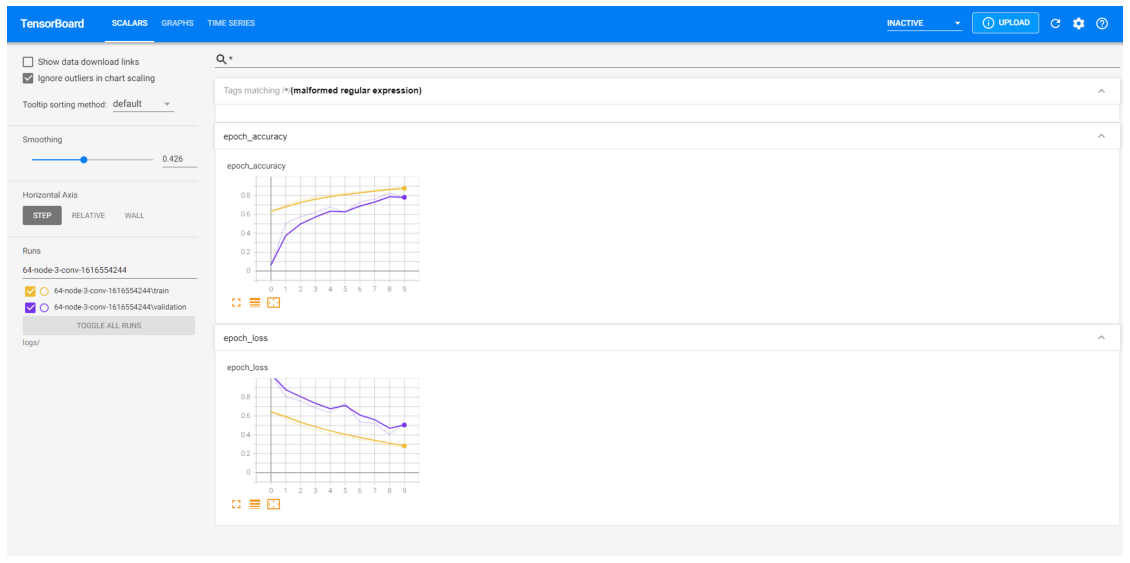

In [44]:
image(r'C:\Users\zhong\Desktop\UOP\project\cat_dog_pic\64node_3conv_10epoch.png')

In [19]:
'''
Below code I used early stopping and model checkpoint to get the best model in 20 epochs
'''
node = [64]
conv_layer = [3]

for conv in conv_layer:
    for size in node:
        model_name = "{}-node-{}-conv-{}".format(size, conv, int(time.time()))

        'Input layer'
        model = Sequential()
        '256 neurons, 3 by 3 filter size'
        model.add(Conv2D(size, (3,3), input_shape = X.shape[1:])) 
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        'This for loop will duplicate convolutional layer depends on the number of layer we want'
        for i in range(conv):
            model.add(Conv2D(size, (3, 3)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

        'We have to flatten the data before going into dense layer'
        model.add(Flatten()) 

        '''Output layer'''
        model.add(Dense(1))
        model.add(Activation('sigmoid'))

        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        
        es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1)
        mc = tf.keras.callbacks.ModelCheckpoint('best_model_cat_dog_128node_2Convlayer.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        model.fit(X, y, batch_size = 32, epochs = 20, validation_split = 0.2, callbacks = [es, mc], verbose = 1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
19968/20000 [============================>.] - ETA: 0s - loss: 0.6538 - accuracy: 0.6246
Epoch 00001: val_accuracy improved from -inf to 0.04500, saving model to best_model_cat_dog_128node_2Convlayer.h5
20000/20000 [==============================] - 8s 387us/sample - loss: 0.6537 - accuracy: 0.6248 - val_loss: 0.8713 - val_accuracy: 0.0450
Epoch 2/20
19968/20000 [============================>.] - ETA: 0s - loss: 0.5906 - accuracy: 0.6799
Epoch 00002: val_accuracy improved from 0.04500 to 0.49600, saving model to best_model_cat_dog_128node_2Convlayer.h5
20000/20000 [==============================] - 7s 358us/sample - loss: 0.5904 - accuracy: 0.6801 - val_loss: 0.8035 - val_accuracy: 0.4960
Epoch 3/20
19872/20000 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.7490
Epoch 00003: val_accuracy improved from 0.49600 to 0.77940, saving model to best_model_cat_dog_128node_2Convlayer.h5
20000/20000 [============